# Spin Dynamics Workshop (Python) — Build a Minimal LLG Code Routine by Routine

By the end of this notebook you will have a **working spin-dynamics code** that:
- reads a lattice and interaction files,
- initializes unit spins,
- computes energy and effective fields (Heisenberg + DMI),
- integrates the LLG equation with a stable predictor–corrector scheme,
- visualizes the final configuration interactively.

Everything is written in **small routines** that you can test immediately after implementing them.


## Install (students)

Run these commands in a terminal (or in a notebook cell with `!`):

```bash
pip install numpy scipy pandas matplotlib tqdm ipympl
```

If you are using **classic Jupyter Notebook**, also enable the ipympl extension (usually one-time):

```bash
jupyter nbextension enable --py --sys-prefix ipympl
```

> If you are on JupyterLab, you typically only need `pip install ipympl` and then restart the kernel.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import trange


## Interactive Matplotlib in Jupyter Notebook (ipympl)

We enable an interactive Matplotlib backend so **the very first 3D visualization is already interactive**.
You will be able to rotate 3D spin configurations with the mouse (click + drag).

If you see a message that ipympl is missing, go back to the install section above and install/enable it.


In [4]:
# Enable interactive plotting (robust fallback).
# If ipympl is unavailable, we fall back to inline plots.

try:
    import ipympl  # noqa: F401
    get_ipython().run_line_magic("matplotlib", "widget")
    print("Matplotlib backend: widget (ipympl) ✅")
except Exception as e:
    print("ipympl not available -> falling back to inline ❌")
    print("Reason:", e)
    get_ipython().run_line_magic("matplotlib", "inline")


Matplotlib backend: widget (ipympl) ✅


# Example 01 — Nanochain (1D, periodic boundary conditions)

## 0) Create toy input files (so everyone can run immediately)

File formats used in this workshop:

### `lattice.in`
Columns:
1. `atom_index` (1..N)
2. `x`
3. `y`
4. `z`

### `jij.in`
Columns:
1. `i` (1..N)
2. `j` (1..N)
3. `Jij` (scalar exchange)

### `dij.in`
Columns:
1. `i`
2. `j`
3. `Dx`
4. `Dy`
5. `Dz`  (DMI vector components)

Below we generate a simple example: a 1D nanochain with nearest-neighbor exchange and a small DMI along `+z`, using **periodic boundary conditions (PBC)**.


In [5]:
# Example 01 inputs: 1D nanochain with periodic boundary conditions (PBC)
N = 10
J = 1.0
D = 0.1

pos = np.zeros((N, 3), float)
pos[:, 0] = np.arange(N)

with open("lattice.in", "w") as f:
    for i in range(N):
        f.write(f"{i+1:4d} {pos[i,0]: .8f} {pos[i,1]: .8f} {pos[i,2]: .8f}\n")

# Nearest-neighbor pairs with PBC:
# i -> i+1 (mod N) and the reverse direction.
pairs = []
for i in range(1, N + 1):               # i is 1-indexed
    j = i + 1 if i < N else 1          # forward neighbor with PBC
    pairs.append((i, j, J))
    pairs.append((j, i, J))

with open("jij.in", "w") as f:
    for i, j, val in pairs:
        f.write(f"{i:4d} {j:4d} {val: .8f}\n")

# DMI along z-hat with antisymmetry Dij = -Dji:
# Define "forward" direction as i -> i+1 (mod N). Then:
#   D_{i,forward} = +D zhat
#   D_{forward,i} = -D zhat
with open("dij.in", "w") as f:
    for i, j, _ in pairs:
        forward = i + 1 if i < N else 1
        sign = +1.0 if (j == forward) else -1.0
        f.write(f"{i:4d} {j:4d} {0.0: .8f} {0.0: .8f} {sign*D: .8f}\n")

print("Wrote (PBC): lattice.in, jij.in, dij.in")


Wrote (PBC): lattice.in, jij.in, dij.in


## Routine 01 — read_lattice

Columns:
1. `atom_index` (1..N)
2. `x`
3. `y`
4. `z`

We read into a DataFrame (inspectable), and return `pos` as `(N,3)`.


In [4]:
def read_lattice(path, N):
    df = pd.read_csv(path, sep=r"\s+", header=None, names=["atom_index", "x", "y", "z"])
    if len(df) != N:
        raise ValueError(f"Expected {N} atoms, got {len(df)} rows")
    df["atom_id0"] = df["atom_index"] - 1
    pos = df[["x", "y", "z"]].to_numpy(float)
    return pos, df

pos, df_lattice = read_lattice("lattice.in", N)
display(df_lattice.head())
print("pos shape:", pos.shape)


,atom_index,x,y,z,atom_id0
0,1,0.0,0.0,0.0,0
1,2,1.0,0.0,0.0,1
2,3,2.0,0.0,0.0,2
3,4,3.0,0.0,0.0,3
4,5,4.0,0.0,0.0,4


pos shape: (10, 3)


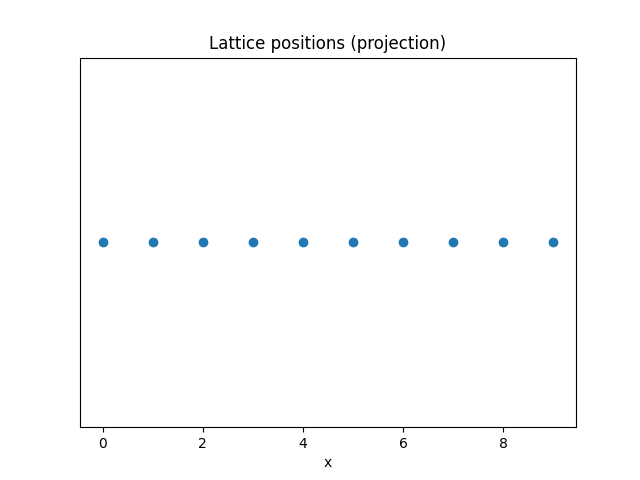

In [6]:
plt.figure()
plt.plot(pos[:, 0], np.zeros_like(pos[:, 0]), marker="o", linestyle="none")
plt.xlabel("x"); plt.yticks([])
plt.title("Lattice positions (projection)")
plt.show()


## Routine 02 — read_jij

Columns:
1. `i` (1..N)
2. `j` (1..N)
3. `Jij`

We build:
- `df_jij` for inspection
- dense matrix `Jij` with shape `(N,N)` (good for small N)


In [7]:
def read_jij(path, N):
    df = pd.read_csv(path, sep=r"\s+", header=None, names=["i", "j", "Jij"])
    df["i0"] = df["i"] - 1
    df["j0"] = df["j"] - 1

    Jij = np.zeros((N, N), float)
    for row in df.itertuples(index=False):
        Jij[int(row.i0), int(row.j0)] = float(row.Jij)
    return Jij, df

Jij, df_jij = read_jij("jij.in", N)
display(df_jij.head())
print("Nonzeros in Jij:", np.count_nonzero(Jij))


,i,j,Jij,i0,j0
0,1,2,1.0,0,1
1,2,1,1.0,1,0
2,2,3,1.0,1,2
3,3,2,1.0,2,1
4,3,4,1.0,2,3


Nonzeros in Jij: 20


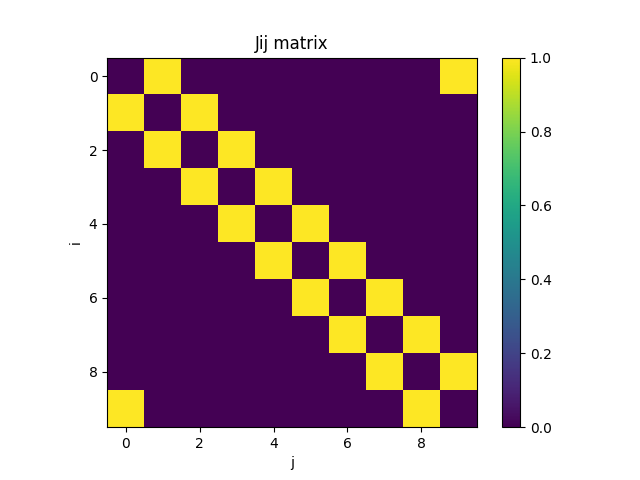

In [7]:
plt.figure()
plt.imshow(Jij)
plt.colorbar()
plt.title("Jij matrix")
plt.xlabel("j"); plt.ylabel("i")
plt.show()


## Routine 03 — read_dij

Columns:
1. `i`
2. `j`
3. `Dx`
4. `Dy`
5. `Dz`

We build:
- `df_dij` for inspection
- dense tensor `Dij` with shape `(N,N,3)` where `Dij[i,j]` is a 3-vector


In [8]:
def read_dij(path, N):
    df = pd.read_csv(path, sep=r"\s+", header=None, names=["i", "j", "Dx", "Dy", "Dz"])
    df["i0"] = df["i"] - 1
    df["j0"] = df["j"] - 1

    Dij = np.zeros((N, N, 3), float)
    for row in df.itertuples(index=False):
        Dij[int(row.i0), int(row.j0), :] = [float(row.Dx), float(row.Dy), float(row.Dz)]
    return Dij, df

Dij, df_dij = read_dij("dij.in", N)
display(df_dij.head())
print("Nonzero Dij vectors:", np.sum(np.linalg.norm(Dij.reshape(-1,3), axis=1) > 0))


,i,j,Dx,Dy,Dz,i0,j0
0,1,2,0.0,0.0,0.1,0,1
1,2,1,0.0,0.0,-0.1,1,0
2,2,3,0.0,0.0,0.1,1,2
3,3,2,0.0,0.0,-0.1,2,1
4,3,4,0.0,0.0,0.1,2,3


Nonzero Dij vectors: 20


## Routine 04 — init_spins (random unit vectors)

We generate random unit vectors uniformly on the sphere.


In [9]:
def random_unit_vector(rng):
    theta = 2*np.pi * rng.random()
    u = 2*rng.random() - 1.0  # u = cos(phi) in [-1,1]
    sinphi = np.sqrt(max(0.0, 1.0 - u*u))
    return np.array([sinphi*np.cos(theta), sinphi*np.sin(theta), u], float)

def init_spins(N, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    spins = np.vstack([random_unit_vector(rng) for _ in range(N)])
    return spins  # (N,3)

rng = np.random.default_rng(0)  # reproducible randomness (change seed to explore)
spins = init_spins(N, rng)
norms = np.linalg.norm(spins, axis=1)
print("norms (min,max):", norms.min(), norms.max())
display(pd.DataFrame(spins, columns=["Sx","Sy","Sz"]).head())


norms (min,max): 0.9999999999999999 1.0


,Sx,Sy,Sz
0,-0.578793,-0.673057,-0.460427
1,0.246583,0.064922,-0.966945
2,0.218502,-0.520373,0.825511
3,-0.696372,-0.551717,0.458993
4,-0.474399,-0.133392,0.870145


## Routine 05 — helpers: cross + normalize

NumPy provides `np.cross`, but we wrap it for readability and to match the “routine-by-routine” style.


In [10]:
def cross(a, b):
    return np.cross(a, b)

def normalize(v, eps=1e-15):
    n = np.linalg.norm(v)
    if n < eps:
        raise ValueError("Tried to normalize a near-zero vector")
    return v / n

print("cross([1,0,0],[0,1,0]) =", cross(np.array([1,0,0.0]), np.array([0,1,0.0])))


cross([1,0,0],[0,1,0]) = [0. 0. 1.]


## Routine 06 — Effective field: `compute_heff`

The effective field drives the LLG dynamics. With our convention:

$$
\mathbf{H}^{\mathrm{eff}}_i = \sum_{j\neq i} J_{ij}\,\mathbf{S}_j \;+\; \sum_{j\neq i}\left(\mathbf{D}_{ij}\times\mathbf{S}_j\right)
$$

Output shape:
- `Heff.shape == (N, 3)` and `Heff[i]` is the vector field acting on atom `i`.


In [11]:
def compute_heff(spins, Jij, Dij):
    N = spins.shape[0]
    Heff = np.zeros_like(spins)
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            Heff[i] += Jij[i, j] * spins[j] + cross(Dij[i, j], spins[j])
    return Heff

Heff = compute_heff(spins, Jij, Dij)
display(pd.DataFrame(Heff, columns=["Hx","Hy","Hz"]).head())


,Hx,Hy,Hz
0,0.030508,1.060110,-1.121570
1,-0.375560,-1.113700,0.365085
2,-0.388125,-0.581091,-0.507952
3,-0.294595,-0.723055,1.695656
4,-0.699951,-0.573576,-0.535530


## Routine 07 — Energy: `calculate_energy`

We use the classical spin Hamiltonian (Heisenberg + DMI):

$$
E = -\sum_{i<j} J_{ij}\,\mathbf{S}_i\cdot\mathbf{S}_j\;-\;\sum_{i<j}\mathbf{D}_{ij}\cdot(\mathbf{S}_i\times\mathbf{S}_j)
$$

Notes:
- The sum is over **pairs** $i<j$ to avoid double counting.
- Spins are **unit vectors**: $\|\mathbf{S}_i\|=1$.


In [12]:
def calculate_energy(spins, Jij, Dij):
    N = spins.shape[0]
    E = 0.0
    for i in range(N - 1):
        for j in range(i + 1, N):
            E -= Jij[i, j] * float(np.dot(spins[i], spins[j]))
            E -= float(np.dot(Dij[i, j], cross(spins[i], spins[j])))
    return E

E0 = calculate_energy(spins, Jij, Dij)
print("Initial energy:", E0)


Initial energy: -0.9213243377039254


## Routine 08 — Time integration: LLG (Heun predictor–corrector)

We integrate the Landau–Lifshitz–Gilbert (LLG) equation:

$$
\frac{d\mathbf{S}}{dt} = -\gamma\,\mathbf{S}\times\mathbf{H}^{\mathrm{eff}}
\;-\;\alpha\gamma\,\mathbf{S}\times\left(\mathbf{S}\times\mathbf{H}^{\mathrm{eff}}\right)
$$

We use **Heun’s method** (predictor–corrector), written in a way that maps directly to code:

1. Compute the field $\,\mathbf{H}^{\mathrm{eff}}(\mathbf{S})\,$ and the torque $\,\dot{\mathbf{S}} = d\mathbf{S}/dt$.
2. **Predictor (Euler):**
   $$
   \mathbf{S}^{\ast} = \mathrm{normalize}\!\left(\mathbf{S} + dt\,\dot{\mathbf{S}}\right)
   $$
3. Recompute $\,\mathbf{H}^{\mathrm{eff}}(\mathbf{S}^{\ast})\,$ and the new torque $\,\dot{\mathbf{S}}^{\ast}$.
4. **Corrector (average torque):**
   $$
   \mathbf{S}_{\mathrm{new}} = \mathrm{normalize}\!\left(\mathbf{S} + \frac{dt}{2}\left(\dot{\mathbf{S}} + \dot{\mathbf{S}}^{\ast}\right)\right)
   $$
5. Renormalization ensures $\|\mathbf{S}_i\|=1$ at every step.

For a first workshop run we use **code units** (stable and easy to see):
- `gamma = 1.0`
- `dt = 0.01`
- `alpha ≈ 0.1 … 1.0`


In [13]:
def llg_torque(S, H, gamma, alpha):
    term1 = -gamma * cross(S, H)
    term2 = -alpha * gamma * cross(S, cross(S, H))
    return term1 + term2

def llg_update_heun(spins, Jij, Dij, dt, gamma, alpha):
    N = spins.shape[0]
    Heff = compute_heff(spins, Jij, Dij)

    dm = np.zeros_like(spins)
    spins_pred = np.zeros_like(spins)

    # Predictor
    for i in range(N):
        dm[i] = llg_torque(spins[i], Heff[i], gamma, alpha)
        spins_pred[i] = normalize(spins[i] + dt * dm[i])

    # Corrector
    Heff_pred = compute_heff(spins_pred, Jij, Dij)
    spins_new = np.zeros_like(spins)
    for i in range(N):
        dm_pred = llg_torque(spins_pred[i], Heff_pred[i], gamma, alpha)
        avg = 0.5 * (dm[i] + dm_pred)
        spins_new[i] = normalize(spins[i] + dt * avg)

    return spins_new

gamma = 1.0
dt = 0.01
alpha = 0.5

spins1 = llg_update_heun(spins, Jij, Dij, dt, gamma, alpha)
print("Norms after 1 step (min,max):", np.linalg.norm(spins1, axis=1).min(), np.linalg.norm(spins1, axis=1).max())
print("Energy before/after:", calculate_energy(spins, Jij, Dij), calculate_energy(spins1, Jij, Dij))


Norms after 1 step (min,max): 0.9999999999999998 1.0
Energy before/after: -0.9213243377039254 -0.9676128938884778


## Full run — combine routines (main loop)

This mirrors reference `do step=1,num_steps` loop:
- update spins
- compute energy
- store energy and magnetization


In [14]:
num_steps = 1

spins_run = spins.copy()
energies = np.zeros(num_steps, float)
times = np.zeros(num_steps, float)
M = np.zeros((num_steps, 3), float)  # average magnetization per atom

for step in trange(num_steps):
    spins_run = llg_update_heun(spins_run, Jij, Dij, dt, gamma, alpha)
    energies[step] = calculate_energy(spins_run, Jij, Dij)
    times[step] = (step + 1) * dt
    M[step] = spins_run.mean(axis=0)  # normalized per atom

print("Final energy:", energies[-1])
print("Final norms (min,max):", np.linalg.norm(spins_run, axis=1).min(), np.linalg.norm(spins_run, axis=1).max())


  0%|          | 0/1 [00:00<?, ?it/s]

Final energy: -0.9676128938884778
Final norms (min,max): 0.9999999999999998 1.0


## Plot: energy vs time


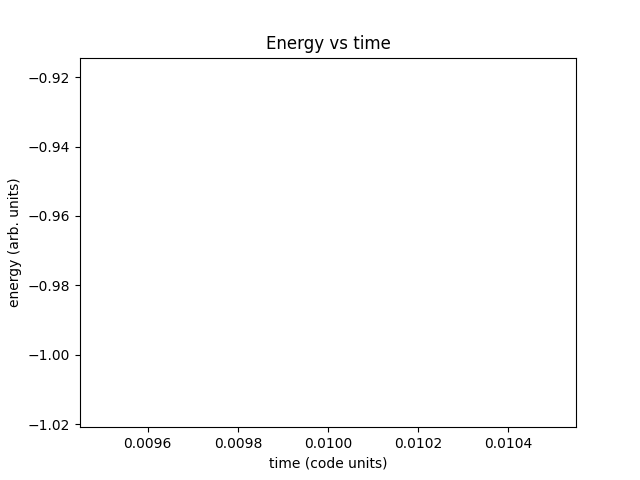

In [15]:
plt.figure()
plt.plot(times, energies)
plt.xlabel("time (code units)")
plt.ylabel("energy (arb. units)")
plt.title("Energy vs time")
plt.show()


## Plot: magnetization vs time


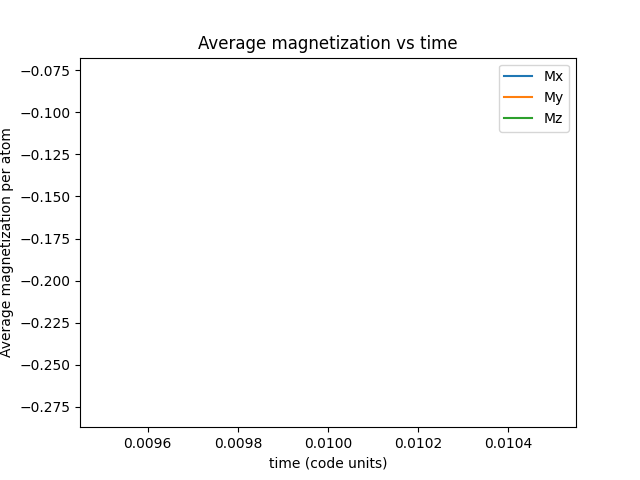

In [16]:
plt.figure()
plt.plot(times, M[:,0], label="Mx")
plt.plot(times, M[:,1], label="My")
plt.plot(times, M[:,2], label="Mz")
plt.xlabel("time (code units)")
plt.ylabel("Average magnetization per atom")
plt.title("Average magnetization vs time")
plt.legend()
plt.show()


## Routine 09 — Visualize the final magnetic configuration (balls + arrows)

We plot:
- **balls**: atomic positions (`pos`)
- **arrows**: spin directions (`spins_run`)

This is a 3D plot using Matplotlib’s `quiver`.
For a 1D/2D lattice, the visualization still works (it just lies in a line/plane).


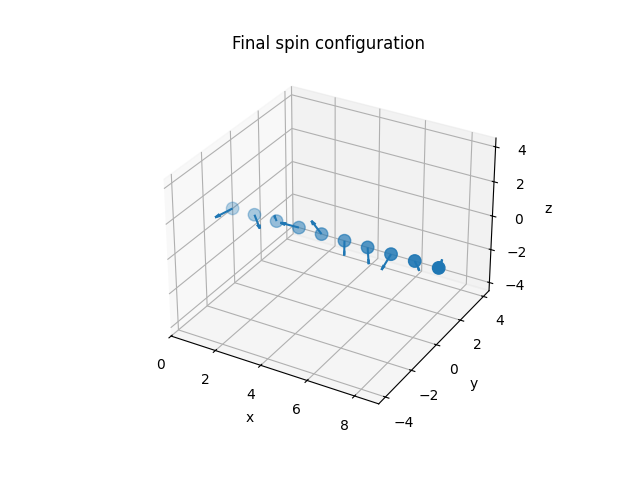

In [17]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)

def plot_spin_configuration(pos, spins, title="Final spin configuration", arrow_length=0.6):
    # pos:   (N,3) atomic positions
    # spins: (N,3) unit vectors

    pos = np.asarray(pos, float)
    spins = np.asarray(spins, float)

    x, y, z = pos[:, 0], pos[:, 1], pos[:, 2]
    u, v, w = spins[:, 0], spins[:, 1], spins[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Balls (atoms)
    ax.scatter(x, y, z, s=80, depthshade=True)

    # Arrows (spins)
    ax.quiver(x, y, z, u, v, w, length=arrow_length, normalize=True)

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    # Nicer scaling (approx equal aspect)
    ranges = np.array([x.max() - x.min(), y.max() - y.min(), z.max() - z.min()], float)
    max_range = ranges.max()
    if max_range == 0:
        max_range = 1.0

    mid_x = 0.5 * (x.max() + x.min())
    mid_y = 0.5 * (y.max() + y.min())
    mid_z = 0.5 * (z.max() + z.min())

    ax.set_xlim(mid_x - max_range / 2, mid_x + max_range / 2)
    ax.set_ylim(mid_y - max_range / 2, mid_y + max_range / 2)
    ax.set_zlim(mid_z - max_range / 2, mid_z + max_range / 2)

    plt.show()

plot_spin_configuration(pos, spins_run, arrow_length=0.8)


# Example 02 — Square lattice skyrmion (20×20, PBC) + Zeeman field

Goal: use a 2D square lattice with **interfacial DMI** and a **perpendicular field** to stabilize a skyrmion.

We will:

1) generate input files (`lattice`, `J_{ij}`, `D_{ij}`) with periodic boundary conditions  
2) choose a **skyrmion‑friendly** $(J, D, B_z)$ parameter set for a **single skyrmion** in a 20×20 cell (rule‑of‑thumb)  
3) run LLG dynamics with damping for two initial conditions:
   - random spins
   - a seeded skyrmion texture  
4) visualize initial and final states (interactive 3D + 2D top view)


## Routine 01 — Build a 20×20 square lattice (periodic boundary conditions)


In [ ]:
# Square lattice geometry
Nx = 20
Ny = 20
spacing = 0.5  # distance between lattice points

N_sq = Nx * Ny

def idx(ix, iy):
    # Map 2D lattice indices -> 1D site index (0-based)
    return (iy % Ny) * Nx + (ix % Nx)

def ij_from_index(i):
    # Inverse mapping 1D -> (ix, iy)
    iy = i // Nx
    ix = i % Nx
    return ix, iy

def create_square_positions(Nx, Ny, spacing):
    pos = np.zeros((Nx * Ny, 3), float)
    for iy in range(Ny):
        for ix in range(Nx):
            i = idx(ix, iy)
            pos[i] = [ix * spacing, iy * spacing, 0.0]
    return pos

pos_sq = create_square_positions(Nx, Ny, spacing)
print("pos_sq shape:", pos_sq.shape)


## Routine 02 — Choose $(J, D, B_z)$ for one skyrmion in a 20×20 cell (rule-of-thumb)

A common back‑of‑the‑envelope estimate for the twist length (pitch) is:

$$
\lambda \approx \frac{2\pi}{\arctan(D/J)} 
\quad \Longrightarrow \quad 
\frac{D}{J} \approx \tan\!\left(\frac{2\pi}{\lambda}\right).
$$

To target **one skyrmion** in a 20×20 simulation cell, we aim for $\lambda \sim 20$ lattice sites:

$$
\frac{D}{J} \approx \tan\!\left(\frac{2\pi}{20}\right) \approx 0.325.
$$

A perpendicular field $B_z$ helps stabilize a skyrmion against spirals.
A practical starting scale is:

$$
B_z \sim c \left(\frac{D}{J}\right)^2 J,
$$

with $c$ an order‑one constant (we start small and encourage a parameter scan).


In [ ]:
# Interaction parameters (dimensionless "code units")
J1 = 1.0              # NN exchange
D_over_J_target = float(np.tan(2 * np.pi / 20.0))  # ~0.325
D = float(D_over_J_target * J1)

# Field scale (heuristic)
Bz = float(0.06 * J1)
B_ext = np.array([0.0, 0.0, Bz], float)

print(f"D/J ≈ {D/J1:.3f}")
print(f"Using D = {D:.3f},  Bz = {Bz:.3f}")


## Routine 03 — Write input files (PBC + antisymmetric DMI)

We use:

- Exchange energy:
$$
E_J = -\sum_{i<j} J_{ij}\,\mathbf{S}_i\cdot\mathbf{S}_j
$$

- DMI energy:
$$
E_D = -\sum_{i<j} \mathbf{D}_{ij}\cdot(\mathbf{S}_i\times\mathbf{S}_j)
$$

DMI must satisfy:
$$
\mathbf{D}_{ji} = -\mathbf{D}_{ij}.
$$

For interfacial DMI (broken inversion along $\hat z$), a standard choice is:
$$
\mathbf{D}_{ij} \propto \hat z \times \hat r_{ij}.
$$


In [ ]:
lattice_path = "lattice_ex02_square.in"
jij_path     = "jij_ex02_square_sk.in"
dij_path     = "dij_ex02_square_sk.in"

def write_lattice_file(pos, filename):
    with open(filename, "w") as f:
        for i, (x, y, z) in enumerate(pos, start=1):  # 1-based IDs in file
            f.write(f"{i}\t{x:.8f}\t{y:.8f}\t{z:.8f}\n")

def write_exchange_and_dmi_square(Nx, Ny, spacing, J1, D, filename_jij, filename_dij):
    # Writes NN exchange Jij and NN interfacial DMI Dij on a square lattice with PBC.
    # Convention:
    #   D_ij = D * ( z_hat × r_hat_ij )
    # with enforced antisymmetry:
    #   D_ji = -D_ij

    N = Nx * Ny
    Jij = np.zeros((N, N), float)
    Dij = np.zeros((N, N, 3), float)

    zhat = np.array([0.0, 0.0, 1.0], float)
    nn_shifts = [(+1, 0), (-1, 0), (0, +1), (0, -1)]

    for iy in range(Ny):
        for ix in range(Nx):
            i = idx(ix, iy)

            for sx, sy in nn_shifts:
                jx = (ix + sx) % Nx
                jy = (iy + sy) % Ny
                j = idx(jx, jy)

                rij = np.array([sx * spacing, sy * spacing, 0.0], float)
                rhat = rij / np.linalg.norm(rij)

                Jij[i, j] = J1

                Dij_vec = D * np.cross(zhat, rhat)
                Dij[i, j, :] = Dij_vec
                Dij[j, i, :] = -Dij_vec

    # Write only nonzero entries
    with open(filename_jij, "w") as fJ:
        for i in range(N):
            for j in range(N):
                if i != j and Jij[i, j] != 0.0:
                    fJ.write(f"{i+1}\t{j+1}\t{Jij[i,j]:.8f}\n")

    with open(filename_dij, "w") as fD:
        for i in range(N):
            for j in range(N):
                if i != j and np.linalg.norm(Dij[i, j]) > 0.0:
                    Dx, Dy, Dz = Dij[i, j]
                    fD.write(f"{i+1}\t{j+1}\t{Dx:.8f}\t{Dy:.8f}\t{Dz:.8f}\n")

    return Jij, Dij

write_lattice_file(pos_sq, lattice_path)
Jij_sq, Dij_sq = write_exchange_and_dmi_square(Nx, Ny, spacing, J1, D, jij_path, dij_path)

print("Wrote:", lattice_path, jij_path, dij_path)


## Routine 04 — Read and inspect the generated inputs


In [ ]:
pos2, df_lat2 = read_lattice(lattice_path, N_sq)
Jij2, df_jij2 = read_jij(jij_path, N_sq)
Dij2, df_dij2 = read_dij(dij_path, N_sq)

display(df_lat2.head())
display(df_jij2.head())
display(df_dij2.head())

print("Jij symmetry check (||J-J^T||):", np.linalg.norm(Jij2 - Jij2.T))
print("Dij antisymmetry check (||D + D^T||):", np.linalg.norm(Dij2 + np.swapaxes(Dij2,0,1)))


## Routine 05 — Neighbor and pair lists (fast $\mathbf{H}^{\mathrm{eff}}$ and energy)


In [ ]:
def build_neighbor_list(Jij, Dij):
    N = Jij.shape[0]
    neigh = [[] for _ in range(N)]
    for i in range(N):
        js = np.where((Jij[i] != 0.0) | (np.linalg.norm(Dij[i], axis=1) > 0.0))[0]
        js = js[js != i]
        for j in js:
            neigh[i].append((int(j), float(Jij[i,j]), Dij[i,j].astype(float)))
    return neigh

def build_pair_list(Jij, Dij):
    N = Jij.shape[0]
    pairs = []
    for i in range(N-1):
        for j in range(i+1, N):
            if Jij[i,j] != 0.0 or np.linalg.norm(Dij[i,j]) > 0.0:
                pairs.append((i, j, float(Jij[i,j]), Dij[i,j].astype(float)))
    return pairs

neigh_sq = build_neighbor_list(Jij2, Dij2)
pairs_sq = build_pair_list(Jij2, Dij2)

print("Average neighbors per site:", np.mean([len(n) for n in neigh_sq]))
print("Number of undirected pairs:", len(pairs_sq))


## Routine 06 — Zeeman term (external field) **implemented here**

A uniform external field $\mathbf{B}$ contributes:

- Energy:
$$
E_Z = -\sum_i \mathbf{B}\cdot \mathbf{S}_i
$$

- Effective field:
$$
\mathbf{H}_i^{\mathrm{eff}} \to \mathbf{H}_i^{\mathrm{eff}} + \mathbf{B}.
$$


In [ ]:
def compute_heff_nlist(spins, neigh):
    N = spins.shape[0]
    Heff = np.zeros_like(spins)
    for i in range(N):
        acc = np.zeros(3, float)
        for (j, J, Dvec) in neigh[i]:
            acc += J * spins[j] + cross(Dvec, spins[j])
        Heff[i] = acc
    return Heff

def calculate_energy_pairs(spins, pairs):
    E = 0.0
    for (i, j, J, Dvec) in pairs:
        E -= J * float(np.dot(spins[i], spins[j]))
        E -= float(np.dot(Dvec, cross(spins[i], spins[j])))
    return float(E)

def total_energy_with_field(spins, pairs, B_ext):
    return calculate_energy_pairs(spins, pairs) - float(np.sum(spins @ B_ext))


## Routine 07 — Fast Heun LLG step (neighbor list + optional field)


In [ ]:
def llg_update_heun_nlist(spins, neigh, dt, gamma, alpha, B_ext=None):
    if B_ext is None:
        B_ext = np.zeros(3, float)

    Heff = compute_heff_nlist(spins, neigh) + B_ext[None, :]

    dm = np.zeros_like(spins)
    spins_pred = np.zeros_like(spins)

    for i in range(spins.shape[0]):
        dm[i] = llg_torque(spins[i], Heff[i], gamma, alpha)
        spins_pred[i] = normalize(spins[i] + dt * dm[i])

    Heff_pred = compute_heff_nlist(spins_pred, neigh) + B_ext[None, :]

    spins_new = np.zeros_like(spins)
    for i in range(spins.shape[0]):
        dm_pred = llg_torque(spins_pred[i], Heff_pred[i], gamma, alpha)
        avg = 0.5 * (dm[i] + dm_pred)
        spins_new[i] = normalize(spins[i] + dt * avg)

    return spins_new


## Routine 08 — Skyrmion initialization (seeded texture)


In [ ]:
def init_skyrmion_texture_pbc(Nx, Ny, spacing, radius, polarity=+1, helicity=0.0):
    spins = np.zeros((Nx*Ny, 3), float)

    cx = 0.5 * (Nx - 1) * spacing
    cy = 0.5 * (Ny - 1) * spacing

    for i in range(Nx*Ny):
        ix, iy = ij_from_index(i)
        x = ix * spacing
        y = iy * spacing

        dx = x - cx
        dy = y - cy
        dx -= np.rint(dx / (Nx*spacing)) * (Nx*spacing)
        dy -= np.rint(dy / (Ny*spacing)) * (Ny*spacing)

        r = np.sqrt(dx*dx + dy*dy)
        phi = np.arctan2(dy, dx)

        w = radius / 4.0
        theta = 2.0 * np.arctan(np.exp((radius - r) / max(w, 1e-12)))

        sx = np.sin(theta) * np.cos(phi + helicity)
        sy = np.sin(theta) * np.sin(phi + helicity)
        sz = polarity * np.cos(theta)

        spins[i] = normalize([sx, sy, sz])

    return spins

rng = np.random.default_rng(0)

spins_init_random = init_spins(N_sq, rng)
spins_init_sk = init_skyrmion_texture_pbc(Nx, Ny, spacing, radius=5.0*spacing, polarity=+1, helicity=0.0)

plot_spin_configuration(pos2, spins_init_random, title="Example 02 — initial (random)", arrow_length=0.8)
plot_spin_configuration(pos2, spins_init_sk, title="Example 02 — initial (seeded skyrmion)", arrow_length=0.8)


## Routine 09 — Run dynamics: random vs skyrmion seed (same $(J,D,B_z)$)


In [ ]:
gamma_ex2 = 1.0
alpha_ex2 = 0.5
dt_ex2 = 0.01

num_steps_ex2 = 800  # increase for cleaner relaxation

def run_relaxation(spins0, neigh, pairs, num_steps, dt, gamma, alpha, B_ext):
    spins = spins0.copy()
    E = np.zeros(num_steps, float)
    Mz = np.zeros(num_steps, float)

    for t in trange(num_steps, desc="LLG relaxation"):
        spins = llg_update_heun_nlist(spins, neigh, dt, gamma, alpha, B_ext=B_ext)
        E[t] = total_energy_with_field(spins, pairs, B_ext)
        Mz[t] = spins[:, 2].mean()  # normalized by N: always in [-1, 1]

    return spins, E, Mz

spins_final_random, E_random, Mz_random = run_relaxation(
    spins_init_random, neigh_sq, pairs_sq, num_steps_ex2, dt_ex2, gamma_ex2, alpha_ex2, B_ext
)
spins_final_sk, E_sk, Mz_sk = run_relaxation(
    spins_init_sk, neigh_sq, pairs_sq, num_steps_ex2, dt_ex2, gamma_ex2, alpha_ex2, B_ext
)

print("Final <Mz> (random init):", Mz_random[-1])
print("Final <Mz> (skyrmion init):", Mz_sk[-1])


### Plot: energy and $\langle M_z\rangle$


In [ ]:
t = np.arange(num_steps_ex2) * dt_ex2

plt.figure()
plt.plot(t, E_random, label="random init")
plt.plot(t, E_sk, label="skyrmion init")
plt.xlabel("time (arb.)")
plt.ylabel("E_total")
plt.legend()
plt.title("Example 02 — Energy vs time")
plt.show()

plt.figure()
plt.plot(t, Mz_random, label="random init")
plt.plot(t, Mz_sk, label="skyrmion init")
plt.xlabel("time (arb.)")
plt.ylabel(r"$\langle M_z\rangle$")
plt.ylim(-1.05, 1.05)
plt.legend()
plt.title("Example 02 — Magnetization vs time")
plt.show()


### Visualize final configurations (interactive 3D)


In [ ]:
plot_spin_configuration(pos2, spins_final_random, title="Example 02 — final (random init)", arrow_length=0.8)
plot_spin_configuration(pos2, spins_final_sk, title="Example 02 — final (skyrmion init)", arrow_length=0.8)


## Routine 10 — Field effect: skyrmion seed with **no field** vs **field** (top view)

We keep the seeded skyrmion initial condition and compare:

- $B_z = 0$
- $B_z > 0$


In [ ]:
def plot_top_view(ax, Nx, Ny, spins, title="Top view"):
    spins = spins.reshape(Ny, Nx, 3)
    X, Y = np.meshgrid(np.arange(Nx), np.arange(Ny))

    U = spins[:, :, 0]
    V = spins[:, :, 1]
    Sz = spins[:, :, 2]

    im = ax.imshow(Sz, origin="lower", vmin=-1, vmax=1)
    ax.quiver(X, Y, U, V, color="k", pivot="mid", scale=40)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return im

spins_final_sk_nofield, E_sk_nofield, Mz_sk_nofield = run_relaxation(
    spins_init_sk, neigh_sq, pairs_sq, num_steps_ex2, dt_ex2, gamma_ex2, alpha_ex2, B_ext=np.array([0.0,0.0,0.0])
)
spins_final_sk_field, E_sk_field, Mz_sk_field = run_relaxation(
    spins_init_sk, neigh_sq, pairs_sq, num_steps_ex2, dt_ex2, gamma_ex2, alpha_ex2, B_ext=B_ext
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im0 = plot_top_view(axes[0], Nx, Ny, spins_final_sk_nofield, title="Skyrmion seed → final (Bz = 0)")
im1 = plot_top_view(axes[1], Nx, Ny, spins_final_sk_field,   title=f"Skyrmion seed → final (Bz = {Bz:.2f})")
fig.colorbar(im1, ax=axes.ravel().tolist(), shrink=0.8, label="Sz")
plt.tight_layout()
plt.show()


# Example 03 — Kagomé lattice: antiferromagnet + $D_z$ DMI (non-collinear, ~120°)

In this example we build a **2D Kagomé lattice** (corner-sharing triangles) with **periodic boundary conditions**.
This is a standard teaching system for **non-collinear magnetism**:

- **Nearest-neighbor antiferromagnetic exchange:** $J<0$ (frustration)
- **Nearest-neighbor DMI:** $\mathbf{D}_{ij} = D_z\,\hat{\mathbf{z}}$ (selects chirality)
- We enforce the key antisymmetry: $\mathbf{D}_{ji} = -\mathbf{D}_{ij}$.

To make the ~120° physics appear reliably in a short run, we initialize the three Kagomé sublattices in a **120° coplanar pattern**
and add a tiny random noise before relaxation.


## Routine 01 — Build the Kagomé lattice (PBC) and write `lattice.in`, `jij.in`, `dij.in`

We use a **triangular Bravais lattice** with lattice vectors:

- $\mathbf{a}_1 = (a, 0)$  
- $\mathbf{a}_2 = (a/2, \sqrt{3}\,a/2)$

and a **3-site basis** (Kagomé):

- $\mathbf{b}_0 = (0, 0)$
- $\mathbf{b}_1 = (a/2, 0)$
- $\mathbf{b}_2 = (a/4, \sqrt{3}a/4)$

Total sites: $N = 3\,n_x\,n_y$.

### PBC + interactions
We write interactions by **index offsets** in the unit-cell grid and apply periodic wrap:
\[
(i_x, i_y)\;\to\;((i_x+\Delta x)\bmod n_x,\; (i_y+\Delta y)\bmod n_y).
\]

### DMI sign convention (guarantees $\mathbf{D}_{ji}=-\mathbf{D}_{ij}$)
For each directed bond $i\to j$, we compute the bond vector $\Delta\mathbf{r} = \mathbf{r}_j-\mathbf{r}_i$
(using the same index offsets), and set

- $D_{ij}^z = +D_z$ if $\Delta y>0$ (or if $\Delta y=0$ and $\Delta x>0$)
- otherwise $D_{ij}^z = -D_z$

Since reversing the bond flips $\Delta\mathbf{r}\to -\Delta\mathbf{r}$, the sign flips automatically.


In [ ]:
import numpy as np

def kagome_lattice_vectors(a: float):
    a1 = np.array([a, 0.0, 0.0], float)
    a2 = np.array([0.5*a, 0.5*np.sqrt(3.0)*a, 0.0], float)
    return a1, a2

def kagome_basis(a: float):
    b0 = np.array([0.0, 0.0, 0.0], float)
    b1 = np.array([0.5*a, 0.0, 0.0], float)
    b2 = np.array([0.25*a, 0.25*np.sqrt(3.0)*a, 0.0], float)
    return [b0, b1, b2]

def kagome_index(ix, iy, s, nx, ny):
    ix = ix % nx
    iy = iy % ny
    return (ix * ny + iy) * 3 + s

def kagome_position(ix, iy, s, a1, a2, basis):
    return ix * a1 + iy * a2 + basis[s]

def create_kagome_lattice(nx: int, ny: int, a: float):
    a1, a2 = kagome_lattice_vectors(a)
    basis = kagome_basis(a)

    positions = np.zeros((3*nx*ny, 3), float)
    sublattice = np.zeros(3*nx*ny, int)

    for ix in range(nx):
        for iy in range(ny):
            for s in range(3):
                g = kagome_index(ix, iy, s, nx, ny)
                positions[g] = kagome_position(ix, iy, s, a1, a2, basis)
                sublattice[g] = s
    return positions, sublattice, a1, a2, basis

# Kagomé NN connectivity by index offsets (PBC applied when mapping to global indices).
# Each site has 4 NN.
KAGOME_NN = {
    0: [(0, 0, 1), (0, 0, 2), (-1, 0, 1), (0, -1, 2)],
    1: [(0, 0, 0), (0, 0, 2), ( 1, 0, 0), (1, -1, 2)],
    2: [(0, 0, 0), (0, 0, 1), ( 0, 1, 0), (-1, 1, 1)],
}

def dmi_sign_from_dr(dr, tol=1e-12):
    if dr[1] > tol:
        return +1
    if abs(dr[1]) <= tol and dr[0] > tol:
        return +1
    return -1

def write_lattice_in_from_positions(pos, filename="lattice.in"):
    with open(filename, "w") as f:
        for i, (x, y, z) in enumerate(pos, start=1):
            f.write(f"{i}\t{x}\t{y}\t{z}\n")

def write_kagome_jij_dij(nx, ny, a1, a2, basis, J=-1.0, Dz=0.35,
                         jij_file="jij.in", dij_file="dij.in"):
    with open(jij_file, "w") as fj, open(dij_file, "w") as fd:
        for ix in range(nx):
            for iy in range(ny):
                for s in range(3):
                    i = kagome_index(ix, iy, s, nx, ny)
                    ri = kagome_position(ix, iy, s, a1, a2, basis)

                    for dx, dy, sp in KAGOME_NN[s]:
                        j = kagome_index(ix + dx, iy + dy, sp, nx, ny)

                        # Exchange (AFM: J<0)
                        fj.write(f"{i+1}\t{j+1}\t{J}\n")

                        # DMI: D = (0,0, ±Dz), with antisymmetry via bond direction
                        rj = kagome_position(ix + dx, iy + dy, sp, a1, a2, basis)  # uses same offsets -> correct bond vector
                        dr = rj - ri
                        sgn = dmi_sign_from_dr(dr)
                        fd.write(f"{i+1}\t{j+1}\t0.0\t0.0\t{sgn*Dz}\n")


# ---- Build + write Kagomé inputs (PBC) ----
nx_k, ny_k = 8, 8
a_k = 0.5

pos_kag, sub_kag, a1_k, a2_k, basis_k = create_kagome_lattice(nx_k, ny_k, a_k)

write_lattice_in_from_positions(pos_kag, "lattice.in")
write_kagome_jij_dij(nx_k, ny_k, a1_k, a2_k, basis_k, J=-1.0, Dz=0.35)

print("Wrote Kagomé inputs (PBC): lattice.in, jij.in, dij.in")
print("Number of atoms:", pos_kag.shape[0])


## Routine 02 — Read + inspect inputs + verify $D_{ij}=-D_{ji}$


In [ ]:
N_kag = 3 * nx_k * ny_k

pos_kag_read, df_lat_kag = read_lattice("lattice.in", N_kag)
Jij_kag, df_jij_kag = read_jij("jij.in", N_kag)
Dij_kag, df_dij_kag = read_dij("dij.in", N_kag)

display(df_lat_kag.head())
display(df_jij_kag.head())
display(df_dij_kag.head())

anti = np.linalg.norm(Dij_kag + np.transpose(Dij_kag, (1,0,2)), axis=2)
print("Max |Dij + Dji| (should be ~0):", anti.max())

neigh_kag = build_neighbor_list(Jij_kag, Dij_kag)
pairs_kag = build_pair_list(Jij_kag, Dij_kag)
print("Average neighbors per site:", np.mean([len(n) for n in neigh_kag]))
print("Unique interacting pairs:", len(pairs_kag))


## Routine 03 — Initialize a 120° coplanar 3-sublattice pattern


In [ ]:
def init_kagome_120(sublattice, rng, noise=0.03):
    base = np.array([
        [ 1.0, 0.0, 0.0],
        [-0.5,  np.sqrt(3)/2, 0.0],
        [-0.5, -np.sqrt(3)/2, 0.0],
    ], float)
    spins = base[sublattice].copy()
    spins += noise * rng.normal(size=spins.shape)
    spins = np.array([normalize(v) for v in spins])
    return spins

spins_kag = init_kagome_120(sub_kag, rng, noise=0.03)
print("Initial M per atom:", spins_kag.mean(axis=0))


## Routine 04 — Run dynamics + check the NN angle histogram


In [ ]:
gamma_kag = 1.0
dt_kag = 0.01
alpha_kag = 0.9

num_steps_kag = 5000

energies_kag = np.zeros(num_steps_kag, float)
times_kag = np.zeros(num_steps_kag, float)
M_kag = np.zeros((num_steps_kag, 3), float)

spins_run_kag = spins_kag.copy()

for step in trange(num_steps_kag):
    Heff = compute_heff_nlist(spins_run_kag, neigh_kag)

    dm = np.zeros_like(spins_run_kag)
    spins_pred = np.zeros_like(spins_run_kag)
    for i in range(N_kag):
        dm[i] = llg_torque(spins_run_kag[i], Heff[i], gamma_kag, alpha_kag)
        spins_pred[i] = normalize(spins_run_kag[i] + dt_kag * dm[i])

    Heff_pred = compute_heff_nlist(spins_pred, neigh_kag)

    spins_new = np.zeros_like(spins_run_kag)
    for i in range(N_kag):
        dm_pred = llg_torque(spins_pred[i], Heff_pred[i], gamma_kag, alpha_kag)
        avg = 0.5 * (dm[i] + dm_pred)
        spins_new[i] = normalize(spins_run_kag[i] + dt_kag * avg)

    spins_run_kag = spins_new

    energies_kag[step] = calculate_energy_pairs(spins_run_kag, pairs_kag)
    times_kag[step] = (step + 1) * dt_kag
    M_kag[step] = spins_run_kag.mean(axis=0)

print("Final energy:", energies_kag[-1])
print("Final M per atom:", M_kag[-1])


### Plots: energy and magnetization (Kagomé)


In [ ]:
plt.figure()
plt.plot(times_kag, energies_kag)
plt.xlabel("time (code units)")
plt.ylabel("energy (arb. units)")
plt.title("Kagomé AFM + Dz: energy vs time")
plt.show()

plt.figure()
plt.plot(times_kag, M_kag[:,0], label="Mx")
plt.plot(times_kag, M_kag[:,1], label="My")
plt.plot(times_kag, M_kag[:,2], label="Mz")
plt.xlabel("time (code units)")
plt.ylabel("Average magnetization per atom")
plt.title("Kagomé AFM + Dz: average magnetization vs time")
plt.legend()
plt.show()


## Nearest-neighbor angle distribution (should cluster near ~120°)


In [ ]:
angles_deg = []
for i, j, J_ij, D_ij in pairs_kag:
    c = float(np.dot(spins_run_kag[i], spins_run_kag[j]))
    c = max(-1.0, min(1.0, c))
    angles_deg.append(np.degrees(np.arccos(c)))

angles_deg = np.array(angles_deg)

print("Mean NN angle (deg):", angles_deg.mean())
print("Std  NN angle (deg):", angles_deg.std())

plt.figure()
plt.hist(angles_deg, bins=40)
plt.xlabel("Nearest-neighbor angle (degrees)")
plt.ylabel("count")
plt.title("Kagomé AFM + Dz: NN angle distribution")
plt.show()


## Visualize the final configuration (Kagomé)


In [ ]:
plot_spin_configuration(pos_kag_read, spins_run_kag, title="Kagomé AFM + Dz: final configuration", arrow_length=0.45)


### Optional: 2D top view (in-plane arrows)


In [ ]:
x = pos_kag_read[:, 0]
y = pos_kag_read[:, 1]
sx = spins_run_kag[:, 0]
sy = spins_run_kag[:, 1]

plt.figure()
plt.scatter(x, y, s=10)
plt.quiver(x, y, sx, sy, angles="xy", scale_units="xy", scale=1.0, width=0.0025)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kagomé AFM + Dz: in-plane spins (top view)")
plt.show()
